## Building and Comparing MNIST Classifier Models

### Imports & settings

In [1]:
# Cell: Imports and global settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb   # make sure xgboost is installed
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
SAMPLE_SIZE = None   # set to an int (e.g., 10000) to run fast prototypes, or None to use full dataset

### Load MNIST

In [2]:
# Cell: Load MNIST (sklearn -> fallback to keras)
from sklearn.datasets import fetch_openml

def load_mnist():
    try:
        mnist = fetch_openml('mnist_784', version=1, as_frame=False)
        X = mnist['data'].astype(np.float32)
        y = mnist['target'].astype(np.int64)
        print("Loaded MNIST via fetch_openml:", X.shape)
    except Exception as e:
        print("fetch_openml failed, trying keras.datasets.mnist. Error:", e)
        try:
            from tensorflow.keras.datasets import mnist as keras_mnist
            (X_train, y_train), (X_test, y_test) = keras_mnist.load_data()
            X = np.vstack([X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)]).astype(np.float32)
            y = np.hstack([y_train, y_test]).astype(np.int64)
            print("Loaded MNIST via keras:", X.shape)
        except Exception as e2:
            raise RuntimeError("Failed to load MNIST with fetch_openml and keras loader.") from e2
    return X, y

X, y = load_mnist()

# Normalize pixel values to [0,1]
X /= 255.0

# Optionally subsample for quick prototyping
if SAMPLE_SIZE is not None:
    np.random.seed(RANDOM_STATE)
    idx = np.random.choice(len(X), size=SAMPLE_SIZE, replace=False)
    X = X[idx]
    y = y[idx]
    print("Subsampled to:", X.shape)

# Train/test split (keep 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Loaded MNIST via fetch_openml: (70000, 784)
Train shape: (56000, 784) Test shape: (14000, 784)


### Utility: train/evaluate

In [4]:
# Cell: training & evaluation helper
from typing import Dict, Any

def train_and_eval(model, name, X_train, y_train, X_test, y_test, max_mis=10):
    """Train `model`, evaluate on test set, return a results dict."""
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    report_str = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # collect misclassified examples indexes
    mis_idx = np.where(y_pred != y_test)[0]
    mis_examples = mis_idx[:max_mis]  # store up to max_mis indices

    results = {
        "name": name,
        "model": model,
        "train_time_sec": train_time,
        "accuracy": acc,
        "report_dict": report,
        "report_str": report_str,
        "confusion_matrix": cm,
        "y_pred": y_pred,
        "mis_samples_idx": mis_examples
    }
    print(f"{name} done — accuracy: {acc:.4f}, train_time: {train_time:.1f}s, misclassified: {len(mis_idx)}")
    return results


### Instantiate models

In [5]:
# Cell: instantiate models
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial', n_jobs=-1, random_state=RANDOM_STATE)),
    ("SVM (RBF)", SVC(kernel='rbf', gamma='scale', random_state=RANDOM_STATE)),
    ("Decision Tree", DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE)),
    ("XGBoost", xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE))
]

# Note: if SVM on full dataset is too slow, consider replacing SVM with SVC(kernel='linear') or reducing SAMPLE_SIZE.


### Train all models and gather results

In [6]:
# Cell: train & evaluate all models
results_list = []
for name, model in models:
    res = train_and_eval(model, name, X_train, y_train, X_test, y_test, max_mis=10)
    results_list.append(res)

Logistic Regression done — accuracy: 0.9219, train_time: 6562.9s, misclassified: 1094
SVM (RBF) done — accuracy: 0.9791, train_time: 575.1s, misclassified: 293
Decision Tree done — accuracy: 0.8743, train_time: 86.0s, misclassified: 1760
Random Forest done — accuracy: 0.9672, train_time: 35.3s, misclassified: 459
XGBoost done — accuracy: 0.9766, train_time: 283.3s, misclassified: 328


### Summary table & bar chart of accuracy and train time

,Model,Accuracy,TrainTimeSec
0,SVM (RBF),0.979071,575.116449
1,XGBoost,0.976571,283.280778
2,Random Forest,0.967214,35.304044
3,Logistic Regression,0.921857,6562.933982
4,Decision Tree,0.874286,86.038883


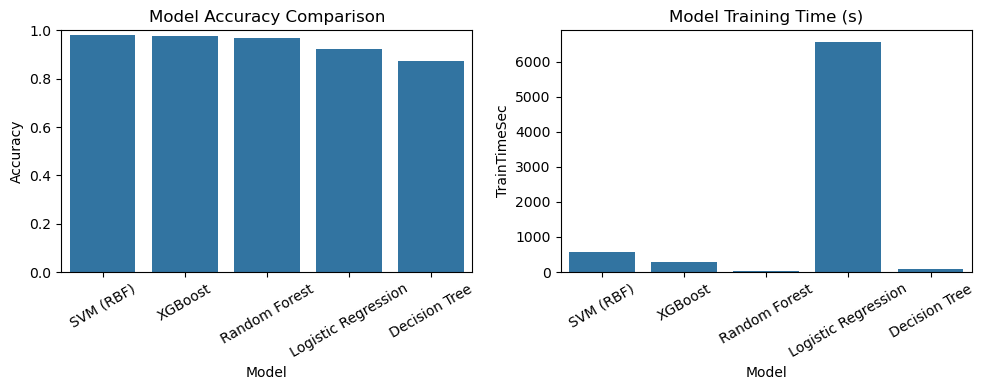

In [7]:
# Cell: summary table and bar chart
summary = pd.DataFrame([{
    "Model": r["name"],
    "Accuracy": r["accuracy"],
    "TrainTimeSec": r["train_time_sec"]
} for r in results_list]).sort_values("Accuracy", ascending=False).reset_index(drop=True)

display(summary)

# Plot accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.barplot(data=summary, x="Model", y="Accuracy")
plt.xticks(rotation=30)
plt.ylim(0,1)
plt.title("Model Accuracy Comparison")

# Plot training times
plt.subplot(1,2,2)
sns.barplot(data=summary, x="Model", y="TrainTimeSec")
plt.xticks(rotation=30)
plt.title("Model Training Time (s)")
plt.tight_layout()
plt.show()


## Print classification reports for each model

In [8]:
# Cell: print classification reports
for r in results_list:
    print("="*80)
    print(r["name"])
    print("-"*80)
    print(r["report_str"])


Logistic Regression
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1381
           1       0.95      0.97      0.96      1575
           2       0.93      0.90      0.91      1398
           3       0.90      0.89      0.89      1428
           4       0.93      0.92      0.93      1365
           5       0.88      0.87      0.88      1263
           6       0.94      0.95      0.95      1375
           7       0.93      0.95      0.94      1459
           8       0.89      0.88      0.89      1365
           9       0.90      0.89      0.90      1391

    accuracy                           0.92     14000
   macro avg       0.92      0.92      0.92     14000
weighted avg       0.92      0.92      0.92     14000

SVM (RBF)
--------------------------------------------------------------------------------
              precision    recall  f1-score   sup

## Confusion matrices (visual)

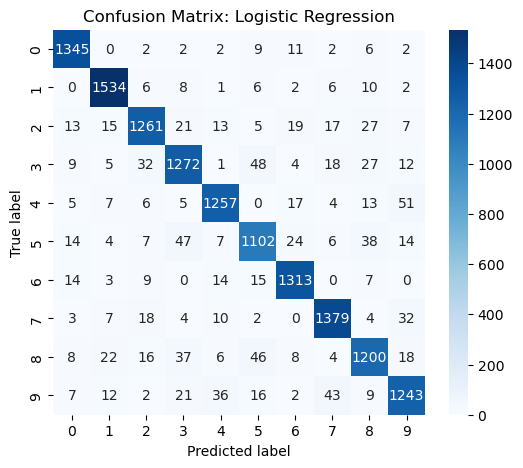

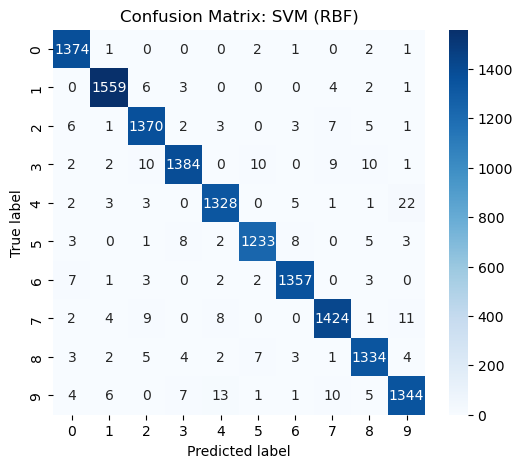

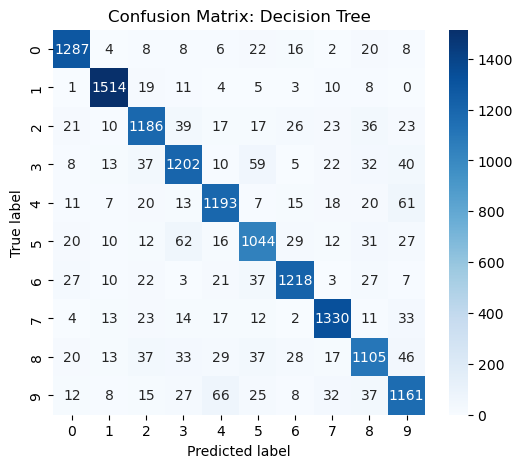

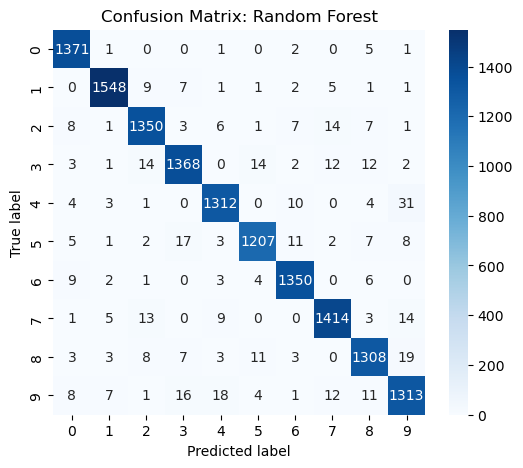

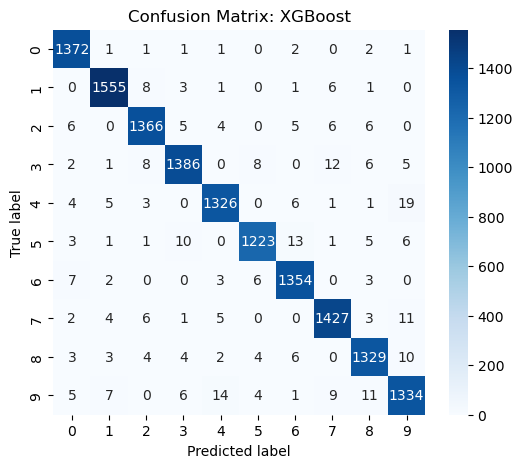

In [9]:
# Cell: confusion matrices
for r in results_list:
    cm = r["confusion_matrix"]
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {r['name']}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

## Show misclassified examples (images) for each model


Model: Logistic Regression


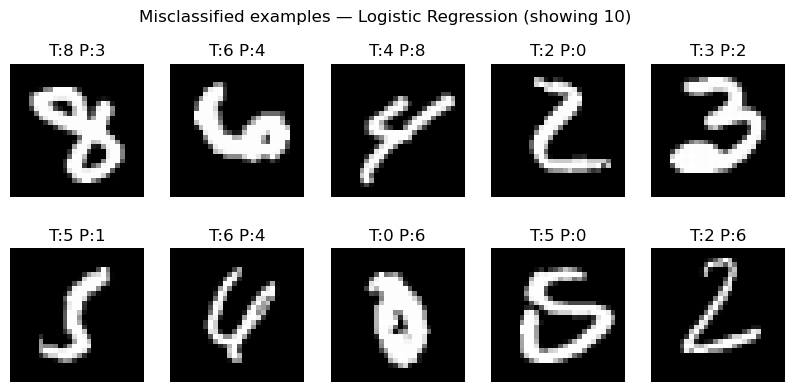


Model: SVM (RBF)


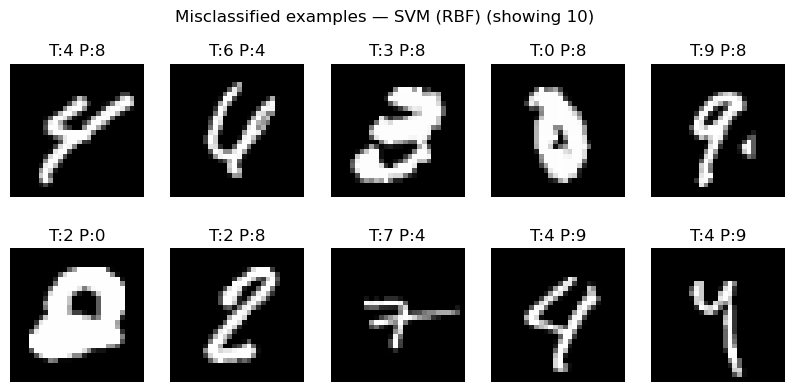


Model: Decision Tree


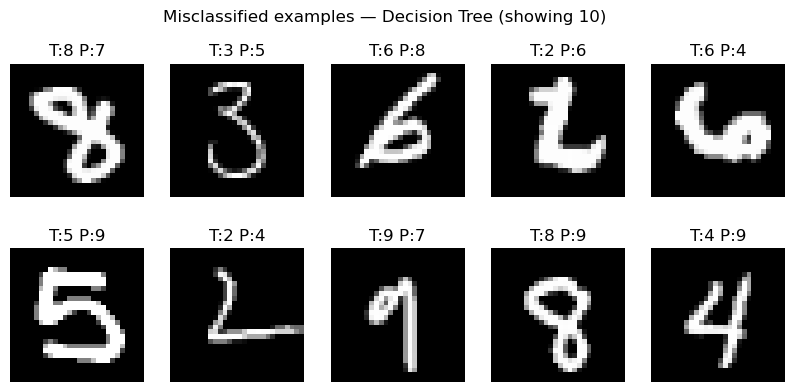


Model: Random Forest


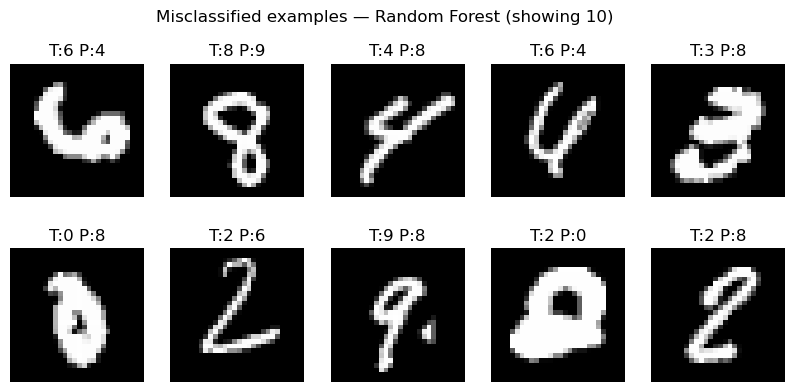


Model: XGBoost


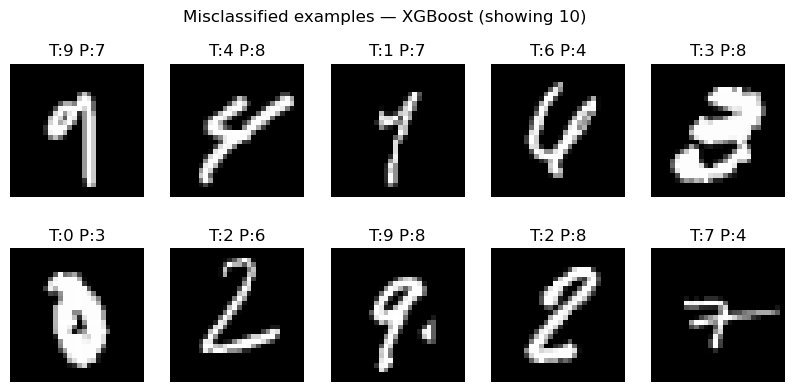

In [10]:
# Cell: display misclassified images
def plot_misclassified(X_test, y_test, mis_idx, y_pred, model_name, ncols=5):
    n = len(mis_idx)
    if n == 0:
        print(f"No misclassified examples for {model_name}")
        return
    nrows = min( (n + ncols - 1) // ncols, 10)
    plt.figure(figsize=(ncols*2, nrows*2.2))
    for i, idx in enumerate(mis_idx):
        if i >= nrows * ncols:
            break
        ax = plt.subplot(nrows, ncols, i+1)
        img = X_test[idx].reshape(28,28)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f"T:{y_test[idx]} P:{y_pred[idx]}")
    plt.suptitle(f"Misclassified examples — {model_name} (showing {min(len(mis_idx), nrows*ncols)})")
    plt.show()

# Run for each model
for r in results_list:
    print("\nModel:", r["name"])
    mis_idxs = r["mis_samples_idx"]
    plot_misclassified(X_test, y_test, mis_idxs, r["y_pred"], r["name"], ncols=5)


## cross-validation and CV accuracy

In [13]:
# Cell: optional cross-validation (slow on full MNIST; consider smaller sample)
from sklearn.model_selection import cross_val_score

DO_CV = True
CV_FOLDS = 3
CV_SAMPLE_SIZE = 5000  # use a smaller sample for cross-val

if DO_CV:
    np.random.seed(RANDOM_STATE)
    sample_idx = np.random.choice(X.shape[0], size=CV_SAMPLE_SIZE, replace=False)
    X_cv = X[sample_idx]
    y_cv = y[sample_idx]
    for name, model in models:
        print(f"Running CV for: {name}")
        t0 = time.time()
        scores = cross_val_score(model, X_cv, y_cv, cv=CV_FOLDS, scoring='accuracy', n_jobs=-1)
        print(f"{name} CV accuracy: mean={scores.mean():.4f}, std={scores.std():.4f}, time={(time.time()-t0):.1f}s")


Running CV for: Logistic Regression
Logistic Regression CV accuracy: mean=0.8856, std=0.0078, time=196.4s
Running CV for: SVM (RBF)
SVM (RBF) CV accuracy: mean=0.9406, std=0.0059, time=27.7s
Running CV for: Decision Tree
Decision Tree CV accuracy: mean=0.7474, std=0.0146, time=9.9s
Running CV for: Random Forest
Random Forest CV accuracy: mean=0.9262, std=0.0110, time=10.8s
Running CV for: XGBoost
XGBoost CV accuracy: mean=0.9230, std=0.0110, time=100.8s


## Task Is Done !